## Importing modules

In [111]:
import numpy as np
import pydicom
import glob
import matplotlib.pyplot as plt
import cv2
from read_roi import read_roi_file
from ipywidgets import interact, IntRangeSlider

## Getting dcm files

In [112]:
dir_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2AX'
files = glob.glob(dir_path + '/*.dcm')

## Reading slice

In [113]:
def rescale(im, max, min):
    return ((im.astype(float) - min) * (1. / (max - min)) * 255.).astype('uint8')


def read_slices(filename):
    name, ext = filename.split('.')

    if ext != 'dcm':
        raise ValueError('Input filename must be a DICOM file')

    slide = pydicom.dcmread(filename).pixel_array

    return slide


# ordering as istance number
z = [float(pydicom.read_file(f, force=True).get(
    "InstanceNumber", "0") - 1) for f in files]
order = np.argsort(z)
files = np.asarray(files)[order]

slice = [read_slices(f) for f in files]

Max = max([x.max() for x in slice])
Min = min([x.min() for x in slice])

slice = [rescale(x, Max, Min) for x in slice]

slice = np.asarray(slice)


### Slice info

In [114]:

depth, height, width = slice.shape
print(
    f"The image object has the following dimensions: depth:{depth}, height: {height}, width:{width}")

The image object has the following dimensions: depth:30, height: 512, width:512


# 2D Exploration

## Plotting Slice

### Random layer plot

Plotting Layer 19 of Image


(-0.5, 511.5, 511.5, -0.5)

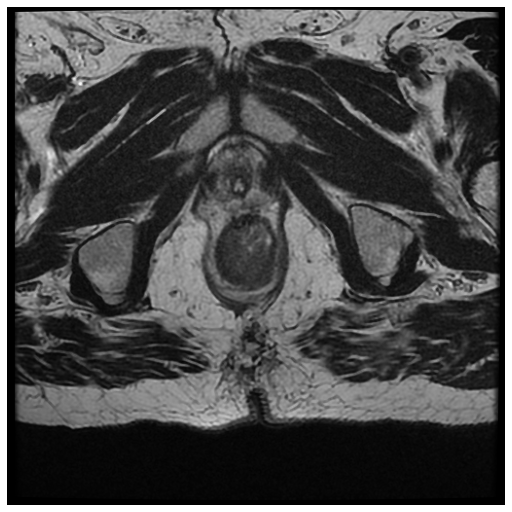

In [115]:
maxval = depth  # Select random layer number
i = np.random.randint(0, maxval)

print(f"Plotting Layer {i} of Image")

plt.figure(figsize=(12, 7), constrained_layout=True)
plt.imshow(slice[i, :, :], cmap='gray')
plt.axis('off')

### Interactive slice plot

In [116]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_slice(layer):
    plt.figure(figsize=(12, 7), constrained_layout=True)
    plt.imshow(slice[layer, :, :], cmap='gray')
    plt.title(f'Exploring Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

## ROIS

### Getting ROIs

In [117]:
roi_path = '/Users/giuseppefilitto/Pazienti_anonym_sorted/BO11/T2ROI'
rois_list = glob.glob(roi_path + '/*.roi')


def _dict(dict_list):
    '''

    useful to get true_dict since roi is {name file : true_dict}.

    '''

    true_dict = []

    for i in dict_list:
        _dict = list(i.values())

        for j in _dict:
            keys = j.keys()
            vals = j.values()

            _dict = {key: val for key, val in zip(keys, vals)}
            true_dict.append(_dict)

    return true_dict

rois = [read_roi_file(roi) for roi in rois_list]
rois = _dict(rois)

# ordering dictionaries by positions and removing rois without x y coords
rois = sorted(rois, key=lambda d: list(d.values())[-1])
rois = list(filter(lambda d: d['type'] != 'composite', rois))

positions = []
xs = []
ys = []
for i in range(len(rois)):
    position = rois[i]['position']
    x = rois[i]['x']
    y = rois[i]['y']

    x.append(x[0])
    y.append(y[0])

    positions.append(position)
    xs.append(x)
    ys.append(y)

### Interactive ROIs plot

In [118]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_roi(layer):
    plt.figure(figsize=(12, 7))
    plt.imshow(slice[layer, :, :], cmap='gray')
    if layer in positions:
        plt.plot(xs[layer - positions[0]], ys[layer - positions[0]], color="red",
                 linestyle='dashed', linewidth=1)
    plt.title(f'Exploring Layer {layer}', fontsize=20)
    plt.axis('off')

    return layer


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Example of ROI

15

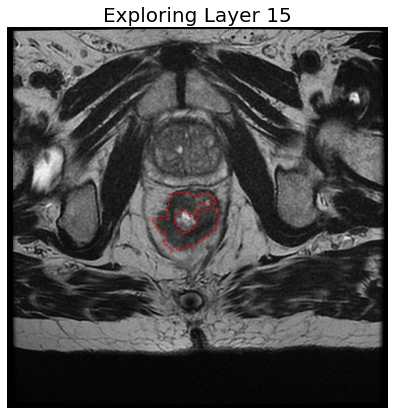

In [119]:
from random import choice 

layer = choice(positions)
explore_roi(layer=layer)

### Interactive ROIs masks

In [120]:

@interact(layer=(positions[0], positions[-1]))
def explore_mask(layer):



    image = slice[layer, :, :].copy()

    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True)

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title(" ROI Mask")
    ax[1].axis('off')

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].plot(xs[layer - positions[0]],ys[layer - positions[0]] , color="red",
                linestyle='dashed', linewidth=1)
    ax[0].set_title("ROI")
    ax[0].axis('off')

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)


interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Output()), _dom_classes=('widge…

### Example of ROI mask

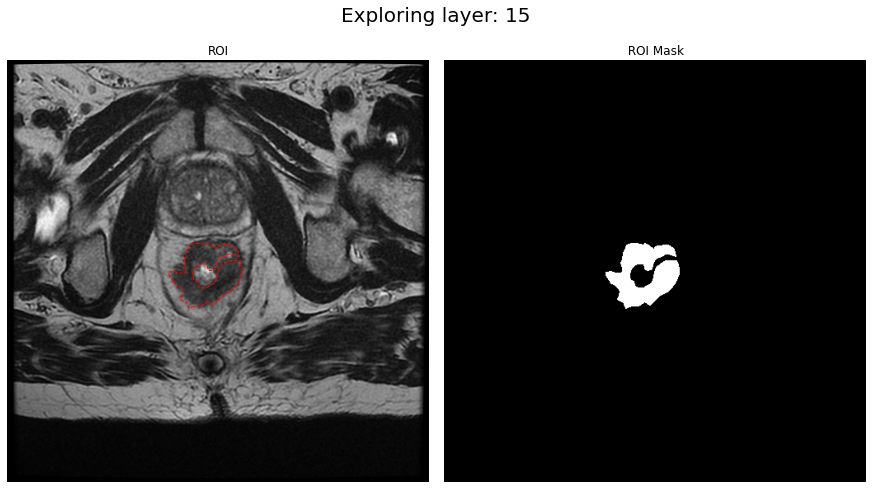

In [121]:
explore_mask(layer=layer)

### Appling ROIs Mask

In [122]:

@interact(layer=(positions[0], positions[-1]))
def explore_masked_image(layer):
    
    image = slice[layer, :, :].copy()

    
    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

    masked_img = cv2.bitwise_and(slice[layer, :, :].copy(), image, mask = mask)

    fig, ax = plt.subplots(1, 3, figsize=(12, 7), constrained_layout=True)

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis('off')

    
    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("ROI Mask")
    ax[1].axis('off')

    ax[2].imshow(masked_img, cmap="gray")
    ax[2].set_title("Applied ROI mask")
    ax[2].axis('off')
    fig.suptitle(f'Exploring layer {layer}', fontsize=20)
        

interactive(children=(IntSlider(value=12, description='layer', max=20, min=4), Output()), _dom_classes=('widge…

### Example of applied mask

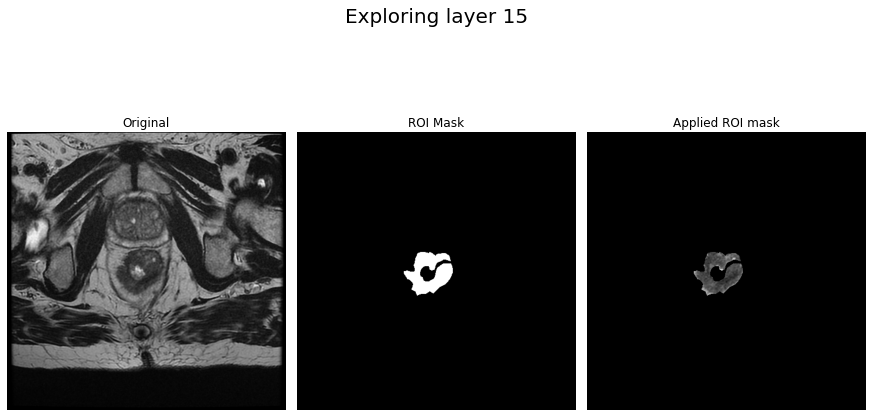

In [123]:
explore_masked_image(layer=layer)

# Traditional image processing segmentation

### Exploring histogram

In [124]:
@interact(layer=(0, slice.shape[0] - 1))
def explore_histogram(layer):

    fig, ax=plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True) 

    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256, [0,256], color="black")
    ax[1].set_title("Histogram")

    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)
    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example 

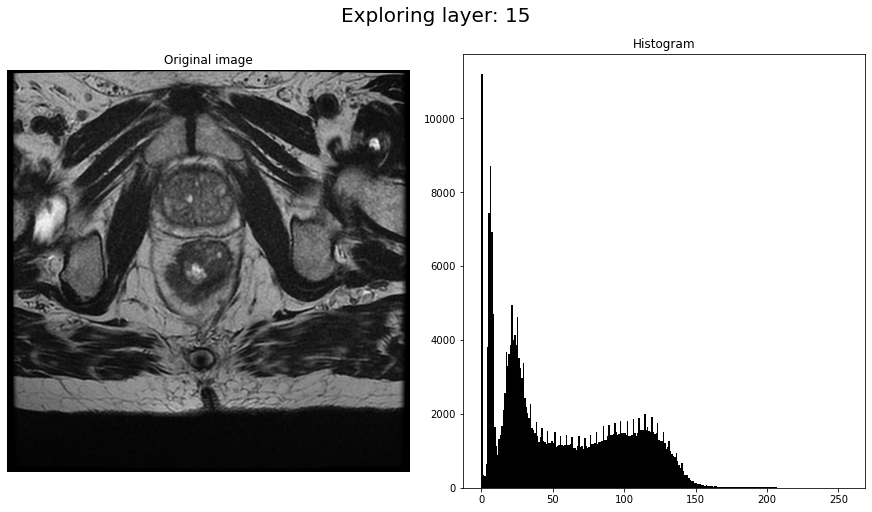

In [125]:
explore_histogram(layer=layer)

### Histogram Global Thresholding

In [126]:
@interact(layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,255], min=0, max=255, step=1, ) )
def manual_tresh(layer, threshold):

    image = slice[layer, : ,:].copy()


    t_min = threshold[0]
    t_max = threshold[1]
    

    mask = cv2.threshold(image, t_min, t_max, cv2.THRESH_BINARY_INV)[1]




    fig, ax=plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True) 


    ax[0].imshow(slice[layer, :, :], cmap="gray")
    ax[0].set_title("Original image")
    ax[0].axis("off")

    ax[1].hist(slice[layer, :, :].ravel(),256,[0,256], color="black")
    ax[1].set_title("Histogram")
    ax[1].vlines(t_min,0, 10000, color="red", linestyle="dashed")
    ax[1].vlines(t_max,0, 10000, color="red", linestyle="dashed")
    ax[1].text(t_min, 10000, "$T_{min}$")
    ax[1].text(t_max, 10000, "$T_{max}$")
    ax[1].set_yticks([])
    


    ax[2].imshow(mask, cmap="gray")
    ax[2].set_title("Thresholded Image")
    ax[2].axis("off")



    fig.suptitle(f"Exploring layer: {layer}",  fontsize=20)

    plt.show()

interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 255), descri…

### Non interactive example

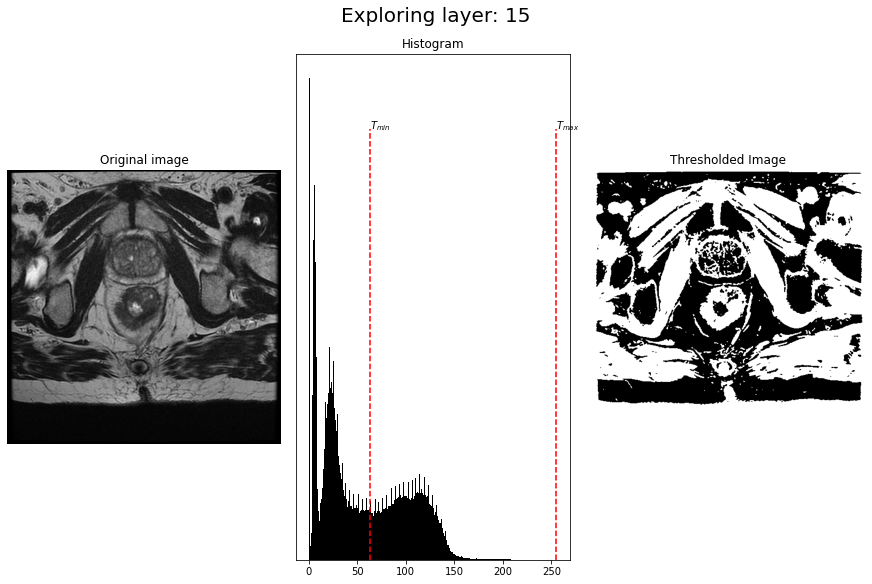

In [127]:
manual_tresh(layer=layer, threshold=(63, 255))

### Adaptive Threshold methods

Text(0.5, 0.98, 'Exploring layer: 15')

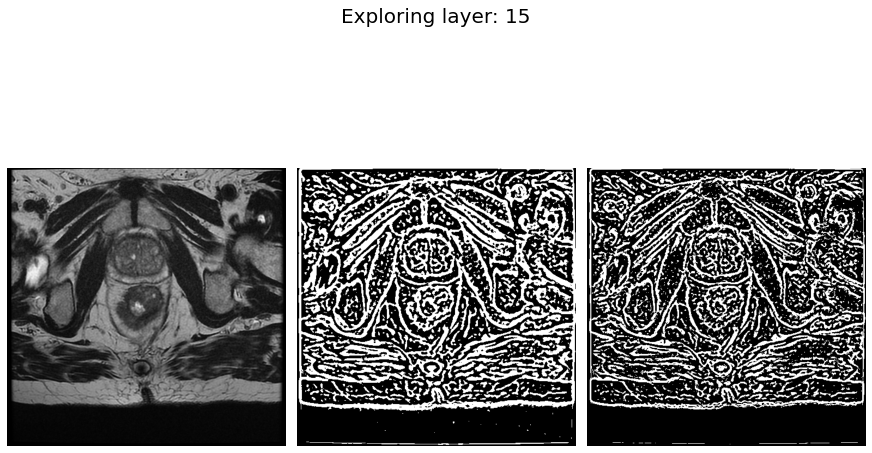

In [128]:

img = image = slice[layer, : ,:].copy()
blur = cv2.medianBlur(img,ksize=5)

th = cv2.adaptiveThreshold(blur,150,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,11,2)
th2 = cv2.adaptiveThreshold(blur,150,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

fig, ax = plt.subplots(1, 3, figsize=(12,8), constrained_layout=True)

ax[0].imshow(img, "gray")
ax[0].axis("off")

ax[1].imshow(th, "gray")
ax[1].axis("off")

ax[2].imshow(th2, "gray")
ax[2].axis("off")

fig.suptitle(f'Exploring layer: {layer}', fontsize=20)

### Otsu

In [129]:
    
 @interact(layer=(0, slice.shape[0] - 1))   
def otsu_thresholding(layer):   

    img = slice[layer, : ,:].copy()
    gauss = cv2.GaussianBlur(img, (5, 5), 0)

    t_min = 0
    t_max = 255

    thresh_otsu = cv2.threshold(gauss,t_min, t_max,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]

    fig, ax = plt.subplots(1, 2, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(slice[layer, : ,:], cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")


    ax[1].imshow(thresh_otsu, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Otsu")

    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)


interactive(children=(IntSlider(value=14, description='layer', max=29), Output()), _dom_classes=('widget-inter…

### Non interactive example

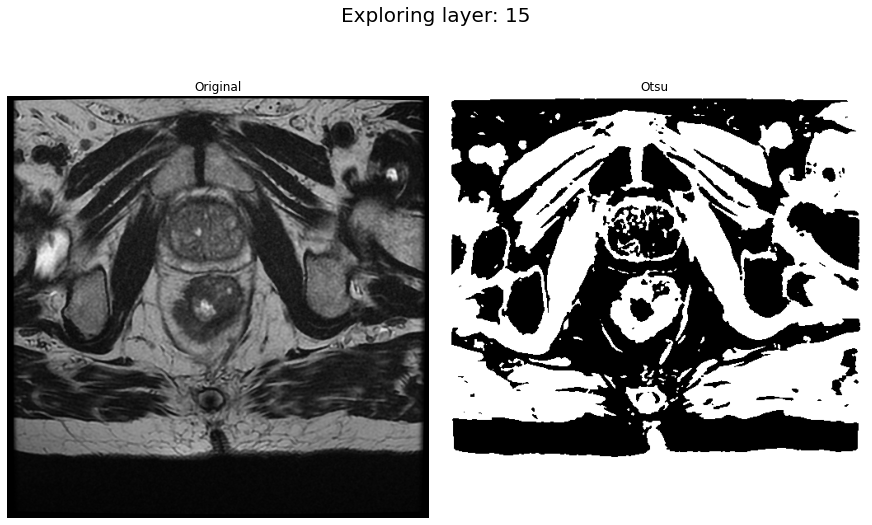

In [130]:
 otsu_thresholding(layer=layer)

### Boxed Masks

In [131]:

@interact(layer=(0, slice.shape[0] - 1), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, description='Global Threshold:') )
def box_fov(layer, threshold):


    img = slice[layer, : ,:].copy()
    box = np.zeros(img.shape[:2], np.uint8)
    box[150:350, 150:350] = 255

    boxed_original = cv2.bitwise_and(img,img,mask = box)

    t_min = threshold[0]
    t_max = threshold[1]

    th = cv2.threshold(img, t_min, t_max, cv2.THRESH_BINARY_INV)[1]
    masked_th = cv2.bitwise_and(th,th,mask = box)

    gauss = cv2.GaussianBlur(img, (5, 5), 0)
    thresh_otsu = cv2.threshold(gauss,0, 256,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    masked_otsu = cv2.bitwise_and(thresh_otsu , thresh_otsu, mask = box)

   
    fig, ax = plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(boxed_original, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Original")


    ax[1].imshow(masked_th, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Global Thresh {t_min, t_max}")

    ax[2].imshow(masked_otsu, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title(f"Otsu")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
    


interactive(children=(IntSlider(value=14, description='layer', max=29), IntRangeSlider(value=(63, 120), descri…

### Non interactive example

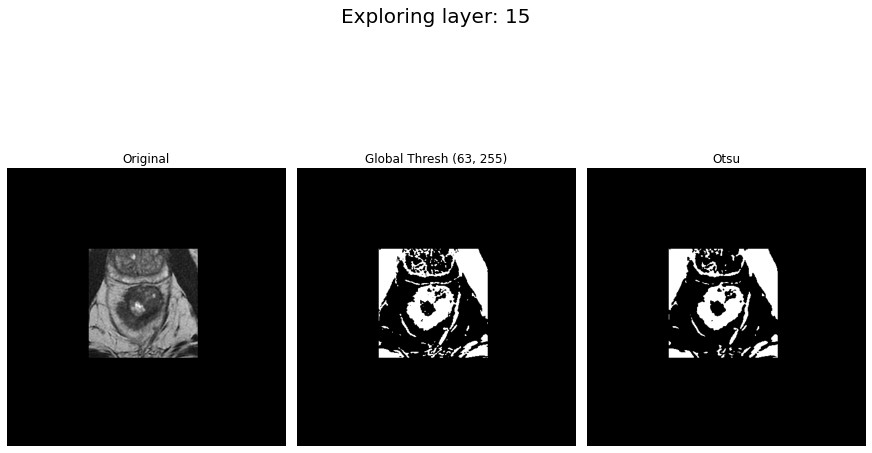

In [132]:
box_fov(layer=layer, threshold=(63, 255))

### Comparing masks

In [ ]:
@interact(layer=(positions[0], positions[-1]), threshold=IntRangeSlider(value=[63,120], min=0, max=255, step=1, description='Global Threshold:') )
def comparing_masks(layer, threshold):

    image = slice[layer, : ,:].copy()
    box = np.zeros(image.shape[:2], np.uint8)
    box[150:350, 150:350] = 255


    pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

    cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
    cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
    true_mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]


    t_min = threshold[0]
    t_max = threshold[1]

    th = cv2.threshold(slice[layer, : ,:].copy(), t_min, t_max, cv2.THRESH_BINARY_INV)[1]
    masked_th = cv2.bitwise_and(th,th,mask = box)

    gauss = cv2.GaussianBlur(slice[layer, : ,:].copy(), (5, 5), 0)
    thresh_otsu = cv2.threshold(gauss,0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    masked_otsu = cv2.bitwise_and(thresh_otsu , thresh_otsu, mask = box)


    fig, ax = plt.subplots(1, 3, figsize=(12, 8), constrained_layout=True)

    ax[0].imshow(true_mask, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Ground truth")


    ax[1].imshow(masked_th, cmap="gray")
    ax[1].axis("off")
    ax[1].set_title(f"Global Thresh {t_min, t_max}")

    ax[2].imshow(masked_otsu, cmap="gray")
    ax[2].axis("off")
    ax[2].set_title("Otsu")
    fig.suptitle(f'Exploring layer: {layer}', fontsize=20)
    

### Non interactive Example

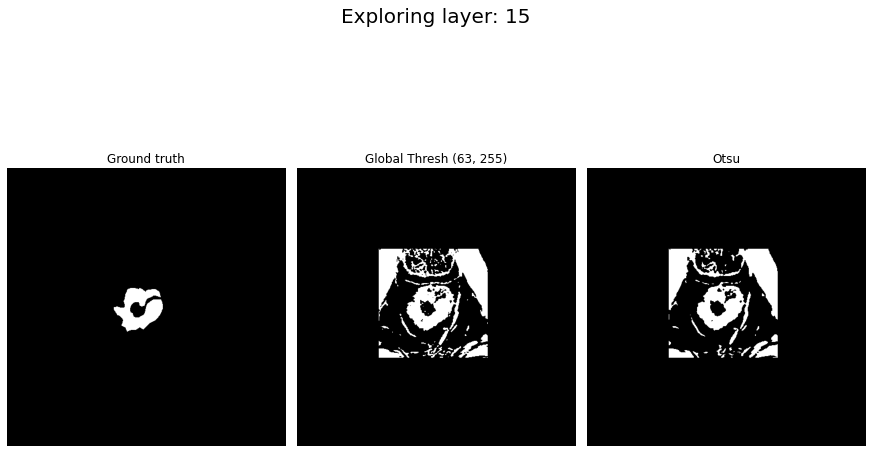

In [133]:
comparing_masks(layer=layer, threshold=(63, 255))

### Gabor filters

Text(0.5, 0.98, 'Exploring layer: 16')

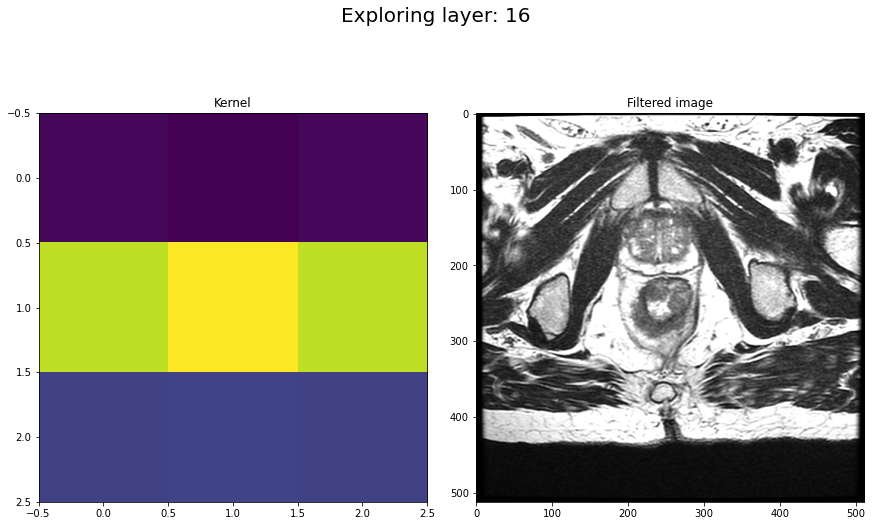

In [136]:

ksize = 3
sigma = 1
theta = 2*np.pi/4
lamb = 1*np.pi/4
gamma = 0.5
phi = 0.2

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamb, gamma, phi, ktype=cv2.CV_32F)

layer = 16
img = slice[layer, :, :].copy()

filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)

fig, ax = plt.subplots(1, 2, figsize=(12, 8 ), constrained_layout=True)

ax[0].imshow(kernel)
ax[0].set_title("Kernel")

ax[1].imshow(filtered_img, cmap="gray")
ax[1].set_title("Filtered image")
fig.suptitle(f'Exploring layer: {layer}', fontsize=20)



# Machine Learning Approach

## Importing modules for ML 

In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from skimage import filters, feature


## Feature extraction

### Labels

In [138]:
def make_labels(slice, layer):

    if not layer in positions:
        print("no labels found!")
        

    else:
        #create layers from given ROI points
        image = slice[layer, :, :].copy()

        
        pts = np.array([(x, y) for(x, y) in zip(xs[layer - positions[0]], ys[layer - positions[0]])])

        cv2.drawContours(image, [pts], -1, (255, 255, 255), -1)
        cv2.polylines(image, [pts], isClosed=True, color=(255, 255, 255), thickness=1)
        label = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY)[1]

        return label

In [139]:
def features_extraction(slice, layer, ksize, Train_mode=False):

    df = pd.DataFrame() # create dataframe for features

    img = slice[layer, :, :].copy()

    img_vect = img.reshape(-1) # reshape 2D image into 1D vector
    df['Original pixels'] = img_vect 


    #generate a bunch of Gabor filters  
    i = 1 
    for theta in np.arange(0, np.pi, np.pi/4):
        for sigma in np.arange(1, 6, 1):
            for lamb in np.arange(0, np.pi, np.pi/4):
                for gamma in np.arange(0,1, 0.5):
                    for phi in np.arange(0,1, 0.5):
                        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamb, gamma, phi, ktype=cv2.CV_32F)

                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        
                        fimg_vect = fimg.reshape(-1)

                        Gabor_label = "Gabor" + str(i)
                        df[Gabor_label] = fimg_vect

                        i += 1



    #roberts
    roberts = filters.roberts(img)
    roberts_vect = roberts.reshape(-1)
    df['roberts'] = roberts_vect

    #sobel
    sobel = filters.sobel(img)
    sobel_vect = sobel.reshape(-1)
    df['sobel'] = sobel_vect

    #scharr
    scharr = filters.scharr(img)
    scharr_vect = scharr.reshape(-1)
    df['scharr'] = scharr_vect

    #prewitt
    prewitt = filters.prewitt(img)
    prewitt_vect = prewitt.reshape(-1)
    df['prewitt'] = prewitt_vect

    #canny
    canny = feature.canny(img, sigma=3)
    canny_vect = canny.reshape(-1)
    df['canny'] = canny_vect


    #gauss
    gauss = cv2.GaussianBlur(img, (ksize, ksize), 0)
    gauss_vect = gauss.reshape(-1)
    df['gauss'] = gauss_vect

    #otsu
    otsu = cv2.threshold(gauss,0, 255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    otsu_vect = otsu.reshape(-1)
    df['otsu'] = otsu_vect



                        
    if Train_mode:

        labels = make_labels(slice, layer)
        labels_vect = labels.reshape(-1)
        df['labels'] = labels_vect

    return df


df = features_extraction(slice=slice, layer=14, ksize=5, Train_mode=True)


## Defining Variables

In [140]:
Y = df['labels'].values
X = df.drop(labels= ['labels'], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=20)

## Random Forest Classifier

In [141]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, Y_train)

prediction_test = model.predict(X_test)
print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))


Accuracy =  0.9833984375


### Most relevant filters

In [142]:

features_list = list(X.columns)
features_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)

pd.options.display.float_format = '{:,.10f}'.format
print(features_imp)

scharr     0.0222959159
prewitt    0.0214697233
sobel      0.0190224835
roberts    0.0177011060
Gabor240   0.0141585498
               ...     
Gabor81    0.0000000000
Gabor225   0.0000000000
Gabor226   0.0000000000
Gabor227   0.0000000000
Gabor164   0.0000000000
Length: 328, dtype: float64


## Pickling model

In [143]:
import pickle

filename = 'RF_model'
pickle.dump(model, open(filename, 'wb')) # wb - write binary 

## Test model predictions 

### Loading model

In [144]:
load_model = pickle.load(open(filename, 'rb')) # rb - read binary 

### Test #1

Text(0.5, 1.0, 'ground truth')

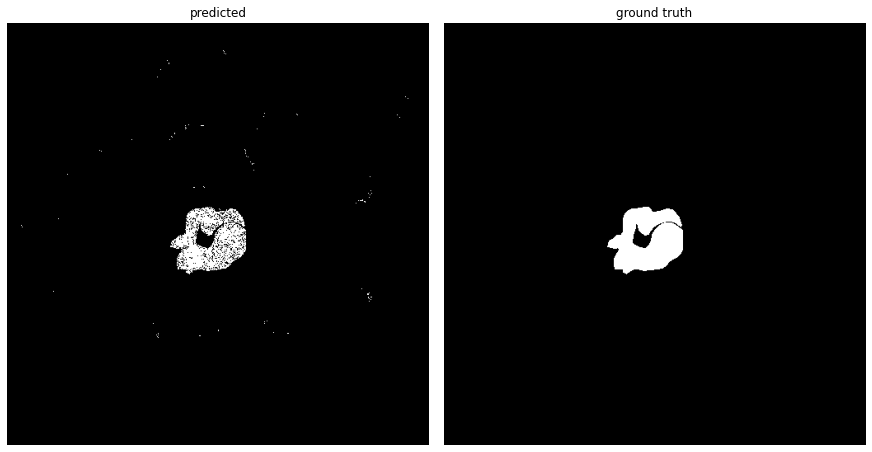

In [145]:
result = load_model.predict(X)

segmented = result.reshape(img.shape)

fig, ax = plt.subplots(1, 2, figsize=(12,8), constrained_layout=True)

ax[0].imshow(segmented, cmap="gray")
ax[0].axis("off")
ax[0].set_title("predicted")

label_img = make_labels(slice=slice, layer=14)

ax[1].imshow(label_img, cmap="gray")
ax[1].axis("off")
ax[1].set_title("ground truth")
